## Prepare Sensor Data for Machine Learning

#### Questions to consider?
* Is the data "clean"?
* Are there anomalies in the data?
* Should we use all the sensors?
* Is the 20Hz frequency a good frequency?
* What would be a good "time window" to aggregate the data given the movements we want to detect?
* What is an appropriate format to feed the algorithm?

### Install and Import required libraries (tools) to work with the data

In [339]:
!pip install ibm-cos-sdk 
!pip install psycopg2-binary

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [340]:
import os
from datetime import datetime, timedelta
import psycopg2

import pandas as pd
import numpy as np

import datetime as dt
from datetime import datetime

import pytz
import time
from datetime import datetime
from dateutil import parser
import scipy.io as sio

import ibm_boto3
from botocore.client import Config

from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

### Specify Database Connection

In [341]:
def connect_to_db(dbname,dbuser,dbpassword,dbhost,dbport,tablename):

    print( f"--- using {tablename} table ---")

    #print(dbname, user, password, host)
    try:
        conn = psycopg2.connect(dbname=dbname, user=dbuser, host=dbhost, port=dbport, password=dbpassword)
        cur = conn.cursor()
        print("connected to DB")
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        print("connection to db failed")

    return cur, conn, tablename

In [342]:
# The code was removed by Watson Studio for sharing.

In [343]:
cur, conn, tablename = connect_to_db(dbname,dbuser,dbpassword,dbhost,dbport,tablename)

--- using sensortraindata table ---
connected to DB


### fetch the data and put it into a dataframe (table) and explore it a little

In [344]:
query = "SELECT * FROM " + tablename

In [345]:
df = pd.read_sql_query(query, conn)

In [346]:
df.tail(20)

,id,username,sensortype,x,y,z,ts,class,device
33180,33181,Maxiphone,gyroscope,206.334850,-38.192950,83.269390,1617960939405,stairs,ios
33181,33182,Maxiphone,accelerometer,10.543465,-0.192883,-4.509478,1617960939454,stairs,ios
33182,33183,Maxiphone,gyroscope,200.077900,-33.192974,85.169820,1617960939455,stairs,ios
33183,33184,Maxiphone,accelerometer,15.981746,-3.864540,-2.834884,1617960939504,stairs,ios
33184,33185,Maxiphone,gyroscope,193.738680,-25.285450,82.977380,1617960939505,stairs,ios
33185,33186,Maxiphone,accelerometer,14.141951,-2.861221,1.337611,1617960939554,stairs,ios
33186,33187,Maxiphone,gyroscope,186.341460,-12.895222,81.804390,1617960939555,stairs,ios
33187,33188,Maxiphone,accelerometer,12.923302,-0.892738,4.532224,1617960939604,stairs,ios
33188,33189,Maxiphone,gyroscope,181.471570,1.252053,83.361590,1617960939605,stairs,ios
33189,33190,Maxiphone,accelerometer,11.609485,0.636259,3.223943,1617960939654,stairs,ios


In [347]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33200 entries, 0 to 33199
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          33200 non-null  int64  
 1   username    33200 non-null  object 
 2   sensortype  33200 non-null  object 
 3   x           33200 non-null  float64
 4   y           33200 non-null  float64
 5   z           33200 non-null  float64
 6   ts          33200 non-null  int64  
 7   class       33200 non-null  object 
 8   device      33200 non-null  object 
dtypes: float64(3), int64(2), object(4)
memory usage: 2.3+ MB


In [348]:
## Wer hat Daten geschickt?
set(df["username"])

{'Max', 'Maxiphone', 'maxandroid', 'maxisses'}

In [349]:
df.describe()

,id,x,y,z,ts
count,33200.000000,33200.000000,33200.000000,33200.000000,3.320000e+04
mean,16600.500000,25.774353,-1.535999,3.985734,1.617916e+12
std,9584.158805,89.177410,13.047104,12.247597,3.517316e+07
min,1.000000,-13.800000,-163.979680,-89.971460,1.617886e+12
25%,8300.750000,0.000000,0.000000,0.000000,1.617887e+12
50%,16600.500000,0.000000,0.000000,0.191114,1.617887e+12
75%,24900.250000,0.100000,0.300000,9.600000,1.617958e+12
max,33200.000000,359.999970,153.049710,89.958300,1.617961e+12


### put in a human readable timestamp

In [350]:
df['timestamp'] = pd.to_datetime(df['ts'], unit='ms')

In [351]:
df['timestamp'][df["username"] == "maxisses"].describe()

count                          19500
unique                         19472
top       2021-04-08 12:57:46.548000
freq                               2
first     2021-04-08 12:54:38.687000
last      2021-04-08 13:12:11.853000
Name: timestamp, dtype: object

In [352]:
df.head(10)

,id,username,sensortype,x,y,z,ts,class,device,timestamp
0,1,maxisses,gyroscope,0.0,0.0,0.0,1617886478687,lying,android,2021-04-08 12:54:38.687
1,2,maxisses,accelerometer,-0.1,1.0,9.5,1617886478689,lying,android,2021-04-08 12:54:38.689
2,3,maxisses,gyroscope,0.0,0.0,0.0,1617886478737,lying,android,2021-04-08 12:54:38.737
3,4,maxisses,accelerometer,0.0,1.0,9.5,1617886478741,lying,android,2021-04-08 12:54:38.741
4,5,maxisses,gyroscope,0.0,0.0,0.0,1617886478787,lying,android,2021-04-08 12:54:38.787
5,6,maxisses,accelerometer,-0.1,1.0,9.5,1617886478792,lying,android,2021-04-08 12:54:38.792
6,7,maxisses,gyroscope,0.0,0.0,0.0,1617886478837,lying,android,2021-04-08 12:54:38.837
7,8,maxisses,accelerometer,-0.1,1.0,9.5,1617886478841,lying,android,2021-04-08 12:54:38.841
8,9,maxisses,gyroscope,0.0,0.0,0.0,1617886478887,lying,android,2021-04-08 12:54:38.887
9,10,maxisses,accelerometer,-0.1,1.0,9.5,1617886478891,lying,android,2021-04-08 12:54:38.891


In [353]:
df.tail(20)

,id,username,sensortype,x,y,z,ts,class,device,timestamp
33180,33181,Maxiphone,gyroscope,206.334850,-38.192950,83.269390,1617960939405,stairs,ios,2021-04-09 09:35:39.405
33181,33182,Maxiphone,accelerometer,10.543465,-0.192883,-4.509478,1617960939454,stairs,ios,2021-04-09 09:35:39.454
33182,33183,Maxiphone,gyroscope,200.077900,-33.192974,85.169820,1617960939455,stairs,ios,2021-04-09 09:35:39.455
33183,33184,Maxiphone,accelerometer,15.981746,-3.864540,-2.834884,1617960939504,stairs,ios,2021-04-09 09:35:39.504
33184,33185,Maxiphone,gyroscope,193.738680,-25.285450,82.977380,1617960939505,stairs,ios,2021-04-09 09:35:39.505
33185,33186,Maxiphone,accelerometer,14.141951,-2.861221,1.337611,1617960939554,stairs,ios,2021-04-09 09:35:39.554
33186,33187,Maxiphone,gyroscope,186.341460,-12.895222,81.804390,1617960939555,stairs,ios,2021-04-09 09:35:39.555
33187,33188,Maxiphone,accelerometer,12.923302,-0.892738,4.532224,1617960939604,stairs,ios,2021-04-09 09:35:39.604
33188,33189,Maxiphone,gyroscope,181.471570,1.252053,83.361590,1617960939605,stairs,ios,2021-04-09 09:35:39.605
33189,33190,Maxiphone,accelerometer,11.609485,0.636259,3.223943,1617960939654,stairs,ios,2021-04-09 09:35:39.654


### Which classes / labels are in our dataset

In [354]:
classes = list(set(df["class"]))
classes

['walking', 'lying', 'stairs']

### sort by user and timestamps

In [355]:
df_sorted = df.sort_values(['username', 'ts'], ascending=[True, True])

In [356]:
df_sorted[df_sorted["username"] == "Maxiphone"].tail()

,id,username,sensortype,x,y,z,ts,class,device,timestamp
33195,33196,Maxiphone,accelerometer,12.203994,-0.308103,2.095525,1617960939804,stairs,ios,2021-04-09 09:35:39.804
33196,33197,Maxiphone,gyroscope,349.838780,134.394040,-62.839672,1617960939805,stairs,ios,2021-04-09 09:35:39.805
33197,33198,Maxiphone,accelerometer,8.092252,-3.426551,2.659660,1617960939854,stairs,ios,2021-04-09 09:35:39.854
33198,33199,Maxiphone,gyroscope,341.947240,128.348920,-47.669678,1617960939855,stairs,ios,2021-04-09 09:35:39.855
33199,33200,Maxiphone,accelerometer,5.932534,-3.720741,3.467704,1617960939904,stairs,ios,2021-04-09 09:35:39.904


### Lets take only the Accelerometer for our first try

#### Give numbers to classes for coloring in 3D scatter

In [357]:
df_sorted['class_num'] = pd.factorize(df_sorted['class'])[0]
colors = np.array(["green", "black", "red"])

In [358]:
df_sorted["class"].unique()

array(['lying', 'walking', 'stairs'], dtype=object)

In [359]:
df_sorted["class_num"].unique()

array([0, 1, 2])

In [360]:
gyro_colors_ios = df_sorted[df_sorted["sensortype"] == "gyroscope"][df["device"] == "ios"]["class_num"]
gyro_colors_android = df_sorted[df_sorted["sensortype"] == "gyroscope"][df["device"] == "android"]["class_num"]

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


Text(0.5, 0.92, 'Accelerometer Data for Android Devices')

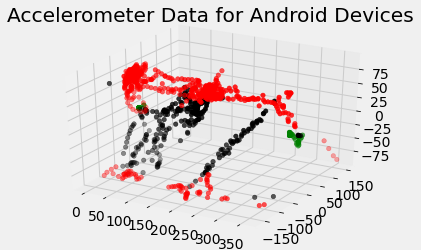

In [361]:
zdata = df[df["sensortype"] == "gyroscope"][df["device"] == "ios"]["z"]
xdata = df[df["sensortype"] == "gyroscope"][df["device"] == "ios"]["x"]
ydata = df[df["sensortype"] == "gyroscope"][df["device"] == "ios"]["y"]
plt.axes(projection='3d').scatter3D(xdata, ydata, zdata, c=colors[gyro_colors_ios])
plt.title("Accelerometer Data for Android Devices")

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


Text(0.5, 0.92, 'Gyroscope Data for Android Devices')

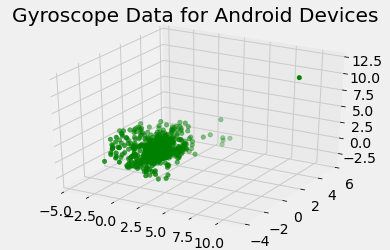

In [362]:
zdata = df[df["sensortype"] == "gyroscope"][df["device"] == "android"]["z"]
xdata = df[df["sensortype"] == "gyroscope"][df["device"] == "android"]["x"]
ydata = df[df["sensortype"] == "gyroscope"][df["device"] == "android"]["y"]
plt.axes(projection='3d').scatter3D(xdata, ydata, zdata, c=colors[gyro_colors_android])
plt.title("Gyroscope Data for Android Devices")

In [363]:
df_sorted = df_sorted[df_sorted["sensortype"]=="accelerometer"]

### Akzelerometer untersuchen

In [364]:
df_sorted.head(21)
### We can see that there are 20 values per second from the accelerometer

,id,username,sensortype,x,y,z,ts,class,device,timestamp,class_num
19500,19501,Max,accelerometer,0.149178,0.104440,-9.754576,1617956016639,lying,ios,2021-04-09 08:13:36.639,0
19502,19503,Max,accelerometer,0.153667,0.100550,-9.762058,1617956016690,lying,ios,2021-04-09 08:13:36.690,0
19504,19505,Max,accelerometer,0.155613,0.098604,-9.753380,1617956016739,lying,ios,2021-04-09 08:13:36.739,0
19506,19507,Max,accelerometer,0.152620,0.100250,-9.755774,1617956016790,lying,ios,2021-04-09 08:13:36.790,0
19508,19509,Max,accelerometer,0.149926,0.098155,-9.749639,1617956016840,lying,ios,2021-04-09 08:13:36.840,0
19510,19511,Max,accelerometer,0.151123,0.098006,-9.757270,1617956016890,lying,ios,2021-04-09 08:13:36.890,0
19512,19513,Max,accelerometer,0.157708,0.100550,-9.755324,1617956016940,lying,ios,2021-04-09 08:13:36.940,0
19514,19515,Max,accelerometer,0.156062,0.099053,-9.753079,1617956016990,lying,ios,2021-04-09 08:13:36.990,0
19516,19517,Max,accelerometer,0.150974,0.094265,-9.759215,1617956017039,lying,ios,2021-04-09 08:13:37.039,0
19518,19519,Max,accelerometer,0.150824,0.103243,-9.762806,1617956017090,lying,ios,2021-04-09 08:13:37.090,0


In [365]:
df_sorted.describe()

,id,x,y,z,ts,class_num
count,16607.000000,16607.000000,16607.000000,16607.000000,1.660700e+04,16607.000000
mean,16597.308063,0.195255,0.655959,5.659503,1.617916e+12,0.125489
std,9582.912277,1.776675,2.725927,7.258357,3.517047e+07,0.434460
min,2.000000,-13.800000,-25.500000,-19.600000,1.617886e+12,0.000000
25%,8294.000000,0.000000,0.057319,7.600000,1.617887e+12,0.000000
50%,16597.000000,0.050586,0.300000,9.600000,1.617887e+12,0.000000
75%,24894.500000,0.100000,1.000000,9.600000,1.617958e+12,0.000000
max,33200.000000,18.049587,24.890570,27.900000,1.617961e+12,2.000000


In [366]:
accel_colors = df_sorted["class_num"]

Text(0.5, 0.92, 'Accelerometer Data for both Device Types')

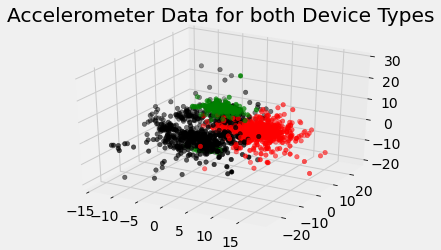

In [367]:
# Data for three-dimensional scattered points
zdata = df_sorted[df_sorted["sensortype"] == "accelerometer"]["z"]
xdata = df_sorted[df_sorted["sensortype"] == "accelerometer"]["x"]
ydata = df_sorted[df_sorted["sensortype"] == "accelerometer"]["y"]
plt.axes(projection='3d').scatter3D(xdata, ydata, zdata, c=colors[accel_colors])
plt.title("Accelerometer Data for both Device Types")

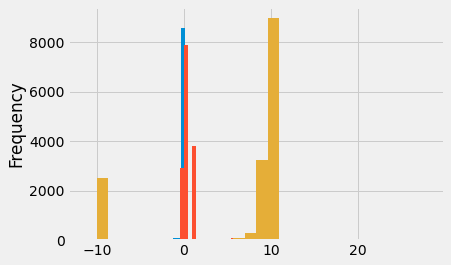

In [368]:
df_sorted[df_sorted["class"] == "lying"]["x"].plot.hist(bins=30)
df_sorted[df_sorted["class"] == "lying"]["y"].plot.hist(bins=30)
df_sorted[df_sorted["class"] == "lying"]["z"].plot.hist(bins=30)

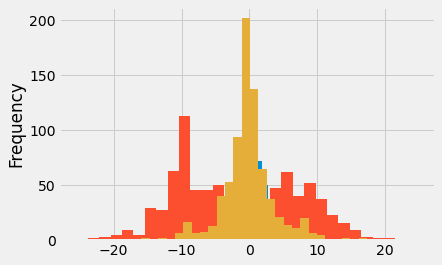

In [369]:
df_sorted[df_sorted["class"] == "walking"]["x"].plot.hist(bins=30)
df_sorted[df_sorted["class"] == "walking"]["y"].plot.hist(bins=30)
df_sorted[df_sorted["class"] == "walking"]["z"].plot.hist(bins=30)

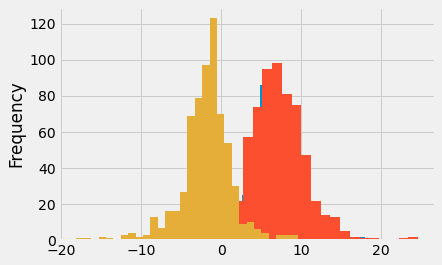

In [370]:
df_sorted[df_sorted["class"] == "stairs"]["x"].plot.hist(bins=30)
df_sorted[df_sorted["class"] == "stairs"]["y"].plot.hist(bins=30)
df_sorted[df_sorted["class"] == "stairs"]["z"].plot.hist(bins=30)

In [371]:
classes = list(set(df_sorted["class"]))
classes

['walking', 'lying', 'stairs']

In [372]:
len(df_sorted.index)

16607

### Put the data into a format feaseable for Machine Learning and Aggregate the data to a certain time window

In [373]:
entries_to_agg = 10
df_new = pd.DataFrame()
my_list = []
my_list_labels = []
my_timestamps = []
for i in range(0,len(df_sorted.index),entries_to_agg):
        my_list.append(df_sorted.iloc[i:i+entries_to_agg,[3,4,5]].values)
        my_list_labels.append(df_sorted.iloc[i:i+entries_to_agg,7].values)
        my_timestamps.append((df_sorted.iloc[i:i+entries_to_agg,9].values))
        if i == 0:
            print(my_list_labels)

[array(['lying', 'lying', 'lying', 'lying', 'lying', 'lying', 'lying',
       'lying', 'lying', 'lying'], dtype=object)]


In [374]:
df_new["time_window"] = my_timestamps
df_new["values"] = my_list
df_new["classes_in_time_window"] = my_list_labels

In [375]:
len(df_new)

1661

In [376]:
df_new.head()

,time_window,values,classes_in_time_window
0,"[2021-04-09T08:13:36.639000000, 2021-04-09T08:...","[[0.14917819, 0.104440264, -9.754576], [0.1536...","[lying, lying, lying, lying, lying, lying, lyi..."
1,"[2021-04-09T08:13:37.139000000, 2021-04-09T08:...","[[0.15621117, 0.092768535, -9.749189], [0.1550...","[lying, lying, lying, lying, lying, lying, lyi..."
2,"[2021-04-09T08:13:37.640000000, 2021-04-09T08:...","[[0.1547148, 0.09621018, -9.747543], [0.156360...","[lying, lying, lying, lying, lying, lying, lyi..."
3,"[2021-04-09T08:13:38.139000000, 2021-04-09T08:...","[[0.15815647, 0.10294388, -9.772383], [0.15920...","[lying, lying, lying, lying, lying, lying, lyi..."
4,"[2021-04-09T08:13:38.639000000, 2021-04-09T08:...","[[0.15561262, 0.09995113, -9.757718], [0.16234...","[lying, lying, lying, lying, lying, lying, lyi..."


In [377]:
df_new["time_window"][0]

array(['2021-04-09T08:13:36.639000000', '2021-04-09T08:13:36.690000000',
       '2021-04-09T08:13:36.739000000', '2021-04-09T08:13:36.790000000',
       '2021-04-09T08:13:36.840000000', '2021-04-09T08:13:36.890000000',
       '2021-04-09T08:13:36.940000000', '2021-04-09T08:13:36.990000000',
       '2021-04-09T08:13:37.039000000', '2021-04-09T08:13:37.090000000'],
      dtype='datetime64[ns]')

In [378]:
data_flat = []
class_in_time_window = []
timewindow_start = []
for i in range(0,len(df_new)-5,1):
    values = np.concatenate((df_new["values"][i]), axis=None)
    classes = np.concatenate((df_new["classes_in_time_window"][i]), axis=None)
    timewindow = np.concatenate((df_new["time_window"][i]), axis=None)
    data_flat.append(values)
    class_in_time_window.append(classes[0])
    timewindow_start.append(timewindow[0])

In [379]:
timewindow_start[0]

numpy.datetime64('2021-04-09T08:13:36.639000000')

In [380]:
timewindow_start[1]

numpy.datetime64('2021-04-09T08:13:37.139000000')

In [381]:
timewindow_start[1] - timewindow_start[0]
## exakt eine halbe Sekunde!

numpy.timedelta64(500000000,'ns')

In [382]:
len(data_flat[0])

30

In [383]:
class_in_time_window[0]

'lying'

### Putting everything into a function

In [384]:
def aggregate_data(df, entries_to_agg=10):
    df_new = pd.DataFrame()
    my_list = []
    my_list_labels = []
    my_timestamps = []
    for i in range(0,len(df.index),entries_to_agg):
            my_list.append(df.iloc[i:i+entries_to_agg,[3,4,5]].values)
            my_list_labels.append(df.iloc[i:i+entries_to_agg,7].values)
            my_timestamps.append((df.iloc[i:i+entries_to_agg,9].values))
    df_new["time_window"] = my_timestamps
    df_new["values"] = my_list
    df_new["classes_in_time_window"] = my_list_labels

    data_flat = []
    class_in_time_window = []
    timewindow_start = []
    for i in range(0,len(df_new)-5,1):
        values = np.concatenate((df_new["values"][i]), axis=None)
        classes = np.concatenate((df_new["classes_in_time_window"][i]), axis=None)
        timewindow = np.concatenate((df_new["time_window"][i]), axis=None)
        data_flat.append(values)
        class_in_time_window.append(classes[0])
        timewindow_start.append(timewindow[0])
    return data_flat, class_in_time_window, timewindow_start

In [385]:
train_X_agg, train_y_agg, time_window = aggregate_data(df_sorted)

In [386]:
set(train_y_agg)

{'lying', 'stairs', 'walking'}

In [387]:
len(train_X_agg[0])

30

In [388]:
time_window[500]

numpy.datetime64('2021-04-09T08:45:22.040000000')

In [389]:
df_prepared = pd.DataFrame(list(zip(train_X_agg, train_y_agg, time_window)), columns=["values", "labels", "time_window_start"])

In [390]:
df_prepared.head()

,values,labels,time_window_start
0,"[0.14917819, 0.104440264, -9.754576, 0.1536673...",lying,2021-04-09 08:13:36.639
1,"[0.15621117, 0.092768535, -9.749189, 0.1550140...",lying,2021-04-09 08:13:37.139
2,"[0.1547148, 0.09621018, -9.747543, 0.1563608, ...",lying,2021-04-09 08:13:37.640
3,"[0.15815647, 0.10294388, -9.772383, 0.15920393...",lying,2021-04-09 08:13:38.139
4,"[0.15561262, 0.09995113, -9.757718, 0.16234632...",lying,2021-04-09 08:13:38.639


In [391]:
len(df_prepared["values"][0])

30

### Save prepared data preserving format

In [392]:
filename = "sensor_data_prepared.pkl"
df_prepared.to_pickle(filename)

In [393]:
!ls

sensor_data_prepared.pkl


In [394]:
import io
from project_lib import Project
sc= None

project = Project(sc,"4b787fdc-f324-4243-ac37-862ad88578d6","p-38ed25004e585910813c8e45e08804ee19ecb155")

with open(filename, 'rb') as z:
        data = io.BytesIO(z.read())
        project.save_data(
            filename, data, set_project_asset=True, overwrite=True
        )

### save modified version for OpenScale and AutoAI as csv

In [395]:
column_names = []
sensor_labels = ["x", "y", "z", "alpha", "gamma", "beta"]
iterations = int(len(df_prepared["values"].tolist()[0])/6)
for i in range(0,iterations, 1):
    sensor_labels_temp = [ current_label + "_" + str(i+1) for current_label in sensor_labels]
    column_names.append(sensor_labels_temp)
column_names = np.concatenate(column_names, axis=None)

In [396]:
df_prepared_openscale = pd.DataFrame(df_prepared["values"].tolist(), columns=column_names)

In [397]:
df_prepared_openscale["classes"] = df_prepared["labels"]
df_prepared_openscale["time_window"] = df_prepared["time_window_start"]

In [398]:
df_prepared_openscale.head()

,x_1,y_1,z_1,alpha_1,gamma_1,beta_1,x_2,y_2,z_2,alpha_2,...,gamma_4,beta_4,x_5,y_5,z_5,alpha_5,gamma_5,beta_5,classes,time_window
0,0.149178,0.104440,-9.754576,0.153667,0.100550,-9.762058,0.155613,0.098604,-9.753380,0.152620,...,0.099053,-9.753079,0.150974,0.094265,-9.759215,0.150824,0.103243,-9.762806,lying,2021-04-09 08:13:36.639
1,0.156211,0.092769,-9.749189,0.155014,0.101896,-9.739463,0.154715,0.102345,-9.752481,0.153518,...,0.104440,-9.751135,0.153817,0.102794,-9.757868,0.148280,0.094564,-9.757569,lying,2021-04-09 08:13:37.139
2,0.154715,0.096210,-9.747543,0.156361,0.098305,-9.766548,0.160401,0.106834,-9.758766,0.154116,...,0.098155,-9.757719,0.168332,0.108630,-9.745897,0.160251,0.106685,-9.758467,lying,2021-04-09 08:13:37.640
3,0.158156,0.102944,-9.772383,0.159204,0.105787,-9.761160,0.149627,0.102944,-9.763704,0.155014,...,0.095013,-9.752631,0.153817,0.096210,-9.765650,0.146784,0.098155,-9.750686,lying,2021-04-09 08:13:38.139
4,0.155613,0.099951,-9.757718,0.162346,0.093666,-9.756372,0.152321,0.101896,-9.762058,0.161598,...,0.109079,-9.757719,0.146335,0.102794,-9.752781,0.152321,0.097407,-9.757869,lying,2021-04-09 08:13:38.639


In [399]:
project.save_data(file_name = "sensor_data_prepared_openscale.csv",data = df_prepared_openscale.to_csv(index=False), set_project_asset=True, overwrite=True)

{'file_name': 'sensor_data_prepared_openscale.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'iotsmartphoneml-donotdelete-pr-pfaqf77fi8ycdy',
 'asset_id': '0adcd472-25b6-426e-b252-c78e0825ba43'}

In [400]:
data_cache = [['maxisses', 'gyroscope', 0, 0, -0.0017453292519943296, 150250724.2], ['maxisses', 'accelerometer', -0.4, 1.1, 9.600000000000001, 150250724.2]]*5

In [401]:
data_cache[0][2:5]

[0, 0, -0.0017453292519943296]

In [402]:
aggregated_data =[]
for item in data_cache:
    aggregated_data = [*aggregated_data, *item[2:5]]
time_window_start = data_cache[0][5]
username = data_cache[0][0]

In [403]:
aggregated_data

[0,
 0,
 -0.0017453292519943296,
 -0.4,
 1.1,
 9.600000000000001,
 0,
 0,
 -0.0017453292519943296,
 -0.4,
 1.1,
 9.600000000000001,
 0,
 0,
 -0.0017453292519943296,
 -0.4,
 1.1,
 9.600000000000001,
 0,
 0,
 -0.0017453292519943296,
 -0.4,
 1.1,
 9.600000000000001,
 0,
 0,
 -0.0017453292519943296,
 -0.4,
 1.1,
 9.600000000000001]

In [404]:
column_names = []
sensor_labels = ["x", "y", "z", "alpha", "gamma", "beta"]
iterations = int(len(aggregated_data)/6)
for i in range(0,iterations, 1):
    sensor_labels_temp = [ current_label + "_" + str(i+1) for current_label in sensor_labels]
    column_names = [*column_names, *sensor_labels_temp]

In [405]:
column_names

['x_1',
 'y_1',
 'z_1',
 'alpha_1',
 'gamma_1',
 'beta_1',
 'x_2',
 'y_2',
 'z_2',
 'alpha_2',
 'gamma_2',
 'beta_2',
 'x_3',
 'y_3',
 'z_3',
 'alpha_3',
 'gamma_3',
 'beta_3',
 'x_4',
 'y_4',
 'z_4',
 'alpha_4',
 'gamma_4',
 'beta_4',
 'x_5',
 'y_5',
 'z_5',
 'alpha_5',
 'gamma_5',
 'beta_5']